In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import matplotlib.pyplot as plt

# Part 1: Fetching Stock Data

In [2]:
def fetch_stock_data(ticker_list, years=5):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years * 365)

    close_data_df = pd.DataFrame()
    volume_data_df = pd.DataFrame()
    dividends_data_df = pd.DataFrame()

    for ticker in ticker_list:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(period='1d', start=start_date, end=end_date)

        # Close Data
        close_data = hist_data['Close'].rename(ticker)
        close_data_df = pd.merge(close_data_df, pd.DataFrame(close_data), left_index=True, right_index=True, how='outer')

        # Volume Data
        volume_data = hist_data['Volume'].rename(ticker)
        volume_data_df = pd.merge(volume_data_df, pd.DataFrame(volume_data), left_index=True, right_index=True, how='outer')

        # Dividends Data
        dividends_data = hist_data['Dividends'].rename(ticker)
        dividends_data_df = pd.merge(dividends_data_df, pd.DataFrame(dividends_data), left_index=True, right_index=True, how='outer')

    return close_data_df, volume_data_df, dividends_data_df

# Fetch the data
ticker_list = ['PG', 'JNJ', 'KO', 'MCD', 'MMM', 'IBM', 'PEP', 'T', 'VZ', 'WMT']
years = 5

close, volume, dividends = fetch_stock_data(ticker_list, years)
close.head()

,PG,JNJ,KO,MCD,MMM,IBM,PEP,T,VZ,WMT
Date,,,,,,,,,,
2018-12-31 00:00:00-05:00,80.992142,112.714729,40.506664,158.174683,155.818451,85.148689,95.905869,14.432825,43.663437,85.720612
2019-01-02 00:00:00-05:00,80.428230,111.579300,40.147373,156.829636,156.153732,86.302315,94.864159,14.938533,43.508099,85.895470
2019-01-03 00:00:00-05:00,79.864319,109.806259,39.899281,155.796310,150.273911,84.579407,93.978714,14.958761,43.663437,85.453751
2019-01-04 00:00:00-05:00,81.494370,111.649155,40.694870,158.807129,156.456345,87.882896,95.905869,15.343096,43.772167,85.987488
2019-01-07 00:00:00-05:00,81.168381,110.932968,40.164482,160.535263,156.096451,88.504623,95.081184,15.621230,44.051754,86.999756


# Part 2: Creating Weights for Benchmarks

## A. Market Volume Weights

In [3]:
def generateMarketVolumeWeights(close, volume):
    dollar_volume = close * volume
    market_volume_weights = dollar_volume.div(dollar_volume.sum(axis=1), axis=0)

    # Shift the DataFrame by one row
    # As the return for the month depends on the allocation defined in the previous month
    shifted_market_volume_weights = market_volume_weights.shift(1)
    return shifted_market_volume_weights

marketVolumeWeights = generateMarketVolumeWeights(close, volume)
marketVolumeWeights.head()

,PG,JNJ,KO,MCD,MMM,IBM,PEP,T,VZ,WMT
Date,,,,,,,,,,
2018-12-31 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 00:00:00-05:00,0.102345,0.145784,0.074778,0.068542,0.049076,0.077464,0.084021,0.176317,0.116849,0.104824
2019-01-03 00:00:00-05:00,0.135904,0.146171,0.079967,0.069226,0.066347,0.065700,0.078739,0.133407,0.104331,0.120207
2019-01-04 00:00:00-05:00,0.118013,0.142996,0.088341,0.087400,0.075936,0.057864,0.084506,0.112065,0.126445,0.106433
2019-01-07 00:00:00-05:00,0.129314,0.148087,0.079535,0.076184,0.070376,0.061819,0.090653,0.128356,0.111990,0.103686


## B. Dividend Yield Weights

In [4]:
def calculateDividendYieldWeights(dividends):
    dividend_cumsum = dividends.cumsum()
    dividend_yield_weights = dividend_cumsum.div(dividend_cumsum.sum(axis=1), axis=0)

    # Shift the DataFrame by one row
    # As the return for the month depends on the allocation defined in the previous month
    shifted_dividend_yield_weights = dividend_yield_weights.shift(1)
    return shifted_dividend_yield_weights

dividendYieldWeights = calculateDividendYieldWeights(dividends)

## C. Returns

In [5]:
def generate_returns(prices):
    return_prices = (prices / prices.shift(1)) - 1
    return return_prices

returns = generate_returns(close)
returns.head()

,PG,JNJ,KO,MCD,MMM,IBM,PEP,T,VZ,WMT
Date,,,,,,,,,,
2018-12-31 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 00:00:00-05:00,-0.006963,-0.010073,-0.008870,-0.008504,0.002152,0.013548,-0.010862,0.035039,-0.003558,0.002040
2019-01-03 00:00:00-05:00,-0.007011,-0.015890,-0.006180,-0.006589,-0.037654,-0.019964,-0.009334,0.001354,0.003570,-0.005143
2019-01-04 00:00:00-05:00,0.020410,0.016783,0.019940,0.019325,0.041141,0.039058,0.020506,0.025693,0.002490,0.006246
2019-01-07 00:00:00-05:00,-0.004000,-0.006415,-0.013033,0.010882,-0.002300,0.007074,-0.008599,0.018128,0.006387,0.011772


## D. Weighted Returns

In [6]:
def generate_weighted_returns(returns, weights):
    return returns * weights

marketVolumeWeightsReturn = generate_weighted_returns(returns, marketVolumeWeights)
dividendYieldWeightsReturns = generate_weighted_returns(returns, dividendYieldWeights)

## E. Cumulative Returns

In [7]:
def calculate_cumulative_returns(returns):
    return (1 + returns.sum(axis = 1)).cumprod()

marketVolumeWeightsCumulativeReturn = calculate_cumulative_returns(marketVolumeWeightsReturn)
dividendYieldWeightsCumulativeReturn = calculate_cumulative_returns(dividendYieldWeightsReturns)

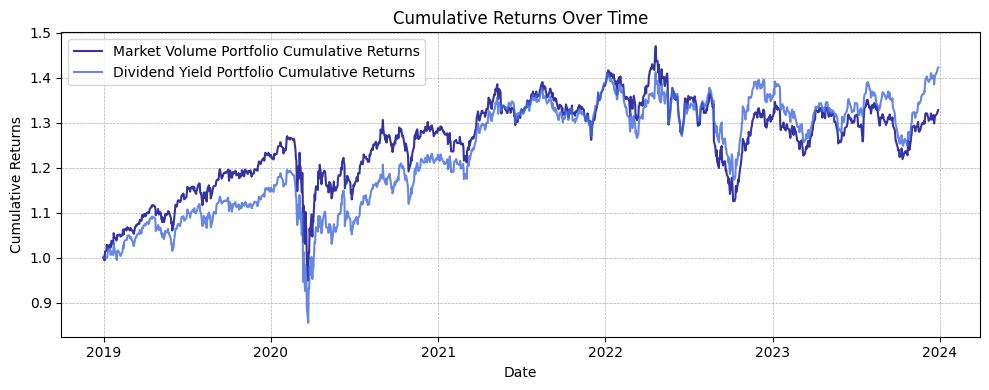

In [17]:
plt.figure(figsize=(10, 4))

plt.plot(marketVolumeWeightsCumulativeReturn, label='Market Volume Portfolio Cumulative Returns', alpha=0.8, color='darkblue')
plt.plot(dividendYieldWeightsCumulativeReturn, label='Dividend Yield Portfolio Cumulative Returns', alpha=0.8, color='royalblue')

plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

# Part 3: Portfolio Optimization (Smart Beta Strategy)

## A. Covariance

In [9]:
def get_covariance_returns(returns):
    return np.cov(returns.T.fillna(0))

covariance_returns = get_covariance_returns(returns)
covariance_returns = pd.DataFrame(covariance_returns, returns.columns, returns.columns)

covariance_returns

,PG,JNJ,KO,MCD,MMM,IBM,PEP,T,VZ,WMT
PG,0.000177,0.000100,0.000115,0.000094,0.000097,0.000106,0.000137,0.000098,0.000084,0.000097
JNJ,0.000100,0.000156,0.000093,0.000080,0.000099,0.000103,0.000105,0.000087,0.000070,0.000071
KO,0.000115,0.000093,0.000181,0.000111,0.000116,0.000123,0.000139,0.000113,0.000084,0.000073
MCD,0.000094,0.000080,0.000111,0.000210,0.000115,0.000120,0.000116,0.000099,0.000066,0.000065
MMM,0.000097,0.000099,0.000116,0.000115,0.000305,0.000164,0.000110,0.000130,0.000086,0.000069
IBM,0.000106,0.000103,0.000123,0.000120,0.000164,0.000272,0.000119,0.000145,0.000093,0.000074
PEP,0.000137,0.000105,0.000139,0.000116,0.000110,0.000119,0.000186,0.000107,0.000086,0.000105
T,0.000098,0.000087,0.000113,0.000099,0.000130,0.000145,0.000107,0.000273,0.000144,0.000068
VZ,0.000084,0.000070,0.000084,0.000066,0.000086,0.000093,0.000086,0.000144,0.000166,0.000063
WMT,0.000097,0.000071,0.000073,0.000065,0.000069,0.000074,0.000105,0.000068,0.000063,0.000193


## B. Weight Optimization

In [10]:
import cvxpy as cvx

def get_optimal_weights(covariance_returns, index_weights, scale=2.0):

    # Create a variable to store the portfolio weights.
    x = cvx.Variable(len(index_weights))

    # Calculate the portfolio variance using the quadratic form.
    portfolio_var = cvx.quad_form(x, covariance_returns)

    # Calculate the distance (L2 norm) between the portfolio weights and the index weights.
    dist_index = cvx.norm(x - index_weights, p=2)

    # Define the objective function: Minimize portfolio variance and distance from the index.
    objective = cvx.Minimize(portfolio_var + scale * dist_index)

    # Define the constraints: Weights should be positive and sum up to 1.
    constraints = [x >= 0, sum(x) == 1]

    # Set up the optimization problem.
    problem = cvx.Problem(objective, constraints)

    # Solve the optimization problem.
    problem.solve()

    # Return the optimal portfolio weights.
    return x.value

## C. Rebalance Portfolio Over Time

In [11]:
def rebalance_portfolio(returns, index_weights, shift_size, chunk_size):

    # Initialize an empty list to store the rebalanced portfolio weights at each interval.
    all_rebalance_weights = []

    # List to store the rebalancing dates.
    rebalance_dates = []

    # Iterate through the historical data in steps of shift_size starting from chunk_size.
    for i in range(chunk_size, len(returns), shift_size):

        # Calculate the covariance matrix of returns over the chunk_size window up to the current period.
        covariance_returns = get_covariance_returns(returns.iloc[i-chunk_size:i])

        # Get the optimal portfolio weights using the covariance matrix and the latest index weights.
        rebalance_weights = get_optimal_weights(covariance_returns, index_weights.iloc[i-1])

        # Append the calculated optimal weights to our list.
        all_rebalance_weights.append(rebalance_weights)

        # Append the rebalance date to our dates list.
        rebalance_dates.append(returns.index[i])

    # Convert the list of optimal weights to a DataFrame with columns named after the assets.
    df_rebalance_weights = pd.DataFrame(all_rebalance_weights, columns=returns.columns)

    # Set the rebalance dates as the index of the resulting DataFrame.
    df_rebalance_weights['Date'] = rebalance_dates
    df_rebalance_weights.set_index('Date', inplace=True)

    # Return the DataFrame.
    return df_rebalance_weights

# Define the size of the window over which covariance is calculated.
chunk_size = 250

# Define the number of periods after which the portfolio will be rebalanced.
shift_size = 5

# Rebalance the portfolio
marketVolumeRebalanceWeights = rebalance_portfolio(returns, marketVolumeWeights, shift_size, chunk_size)

# Rebalance the portfolio
dividendYieldRebalanceWeights = rebalance_portfolio(returns, dividendYieldWeights, shift_size, chunk_size)

## D. Cumulative Returns Calculation

In [12]:
def calculate_cumulative_portfolio_returns(returns, rebalance_weights):
    # Initializing the series for portfolio returns
    portfolio_returns = pd.Series(index=returns.index)

    # Example usage of the function with example data
    n_col = len(rebalance_weights.columns)
    initial_weights = pd.Series([1/n_col] * n_col, index=rebalance_weights.columns)

    # Setting current weights to initial weights
    current_weights = initial_weights

    # Iterating through each date in the returns dataframe
    for date, daily_returns in returns.iterrows():
        if date != returns.index.min():
            # Check if there's a rebalance for this date and update weights if needed
            if date in rebalance_weights.index:
                current_weights = rebalance_weights.loc[date]

            # Calculating the daily portfolio return
            portfolio_return = (daily_returns * current_weights).sum()
            portfolio_returns[date] = portfolio_return

            # Adjusting current_weights based on daily returns
            current_weights *= (1 + daily_returns)

            # Normalizing the weights so they sum up to 1
            current_weights /= current_weights.sum()

    # Calculating cumulative portfolio returns
    cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

    return cumulative_portfolio_returns

# Calculate cumulative returns
optimizedmarketVolumeWeightsCumulativeReturn = calculate_cumulative_portfolio_returns(returns, marketVolumeRebalanceWeights)
optimizeddividendYieldWeightsCumulativeReturn = calculate_cumulative_portfolio_returns(returns, dividendYieldRebalanceWeights)

<ipython-input-12-09e81fb2d8a1>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_returns = pd.Series(index=returns.index)


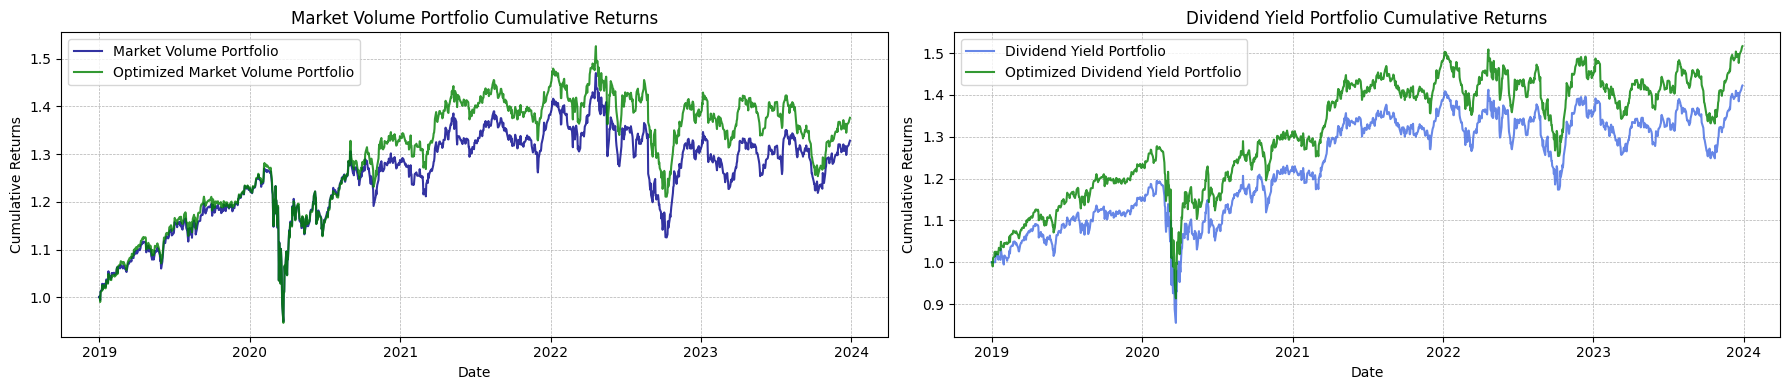

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

ax1.plot(marketVolumeWeightsCumulativeReturn, label='Market Volume Portfolio', alpha=0.8, color='darkblue')
ax1.plot(optimizedmarketVolumeWeightsCumulativeReturn, label='Optimized Market Volume Portfolio', alpha=0.8, color='green')
ax1.set_title('Market Volume Portfolio Cumulative Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2.plot(dividendYieldWeightsCumulativeReturn, label='Dividend Yield Portfolio', alpha=0.8, color='royalblue')
ax2.plot(optimizeddividendYieldWeightsCumulativeReturn, label='Optimized Dividend Yield Portfolio', alpha=0.8, color='green')
ax2.set_title('Dividend Yield Portfolio Cumulative Returns')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Returns')
ax2.legend(loc='upper left')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## E. Return to Volatility Ratio

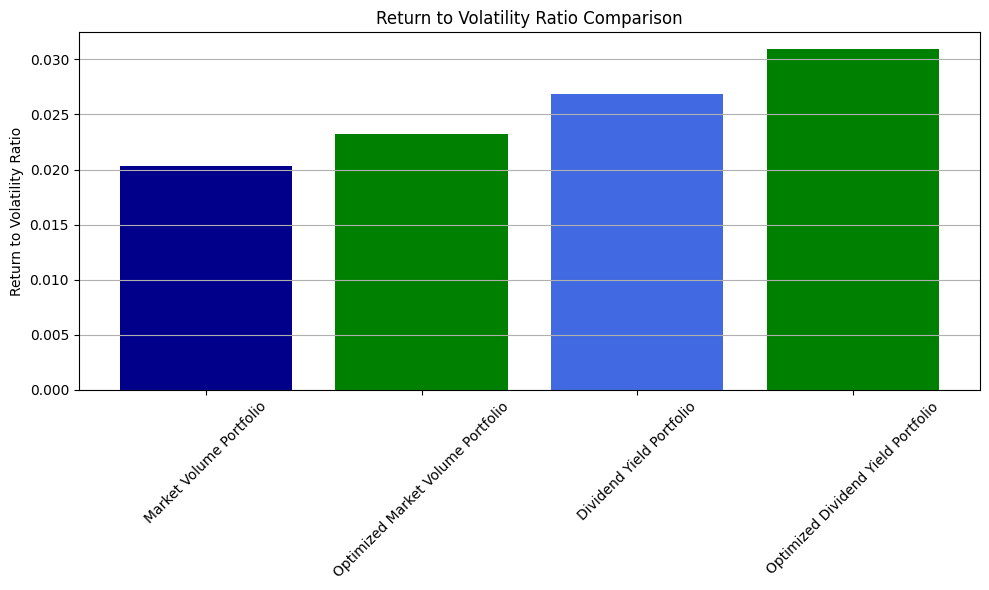

In [19]:
def return_to_volatility_ratio(portfolio_returns):
    mean_return = portfolio_returns.mean()
    std_return = portfolio_returns.std()
    ratio = mean_return / std_return
    return ratio

# Calculating return_to_volatility_ratio for each portfolio
ratios = {
    'Market Volume Portfolio': return_to_volatility_ratio(marketVolumeWeightsCumulativeReturn.diff().dropna()),
    'Optimized Market Volume Portfolio': return_to_volatility_ratio(optimizedmarketVolumeWeightsCumulativeReturn.diff().dropna()),
    'Dividend Yield Portfolio': return_to_volatility_ratio(dividendYieldWeightsCumulativeReturn.diff().dropna()),
    'Optimized Dividend Yield Portfolio': return_to_volatility_ratio(optimizeddividendYieldWeightsCumulativeReturn.diff().dropna())
}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color=['darkblue', 'green', 'royalblue', 'green'])
plt.title('Return to Volatility Ratio Comparison')
plt.ylabel('Return to Volatility Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()